In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from interpolating_match import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [2]:
def analytic_phase_consistent(abs_SNRs, ang_SNRs):

    angle_arg = 2*ang_SNRs[0]-ang_SNRs[1]-ang_SNRs[2]
    condition = np.abs(angle_arg - np.round(angle_arg/(2*np.pi),0)*2*np.pi) <= np.pi/2

    if condition:
        cross_term_sqrd = abs_SNRs[1]**4 + 2*abs_SNRs[1]**2*abs_SNRs[-1]**2*np.cos(2*angle_arg) + abs_SNRs[-1]**4
        log_L = 0.25*(abs_SNRs[1]**2+abs_SNRs[-1]**2+np.sqrt(cross_term_sqrd))
    else:
        print('fail')
        log_L = 0.5*np.max([abs_SNRs[1]**2, abs_SNRs[-1]**2])
    higher_SNR = np.sqrt(2*log_L)
    
    return higher_SNR/abs_SNRs[0]  

In [3]:
mags = [7,0.5,0.5]
angs = [0,np.pi/2,0]
print(2*angs[0]-angs[1]-angs[2])
print(np.sqrt(mags[1]**2+mags[2]**2)/mags[0])
print(comb_harm_consistent(mags, angs))
print(analytic_phase_consistent(mags, angs))

-1.5707963267948966
0.10101525445522108
0.07179447841095439
0.07142857142857142


In [4]:
mags = [7,0.5,0.5]
angs = [0,np.pi/2+np.pi/2,-np.pi/2]
print(2*angs[0]-angs[1]-angs[2])
print(np.sqrt(mags[1]**2+mags[2]**2)/mags[0])
print(comb_harm_consistent(mags, angs))
print(analytic_phase_consistent(mags, angs))

-1.5707963267948966
0.10101525445522108
0.07142858161693205
0.07142857142857142


In [6]:
# Time numerical approach
n_n = 1000
start = time.time()
for i in range(n_n):
    comb_harm_consistent(mags, angs)
end = time.time()
time_n = end-start
print(f'Numerical: {n_n/time_n} samples per second.')

# Time analytical approach
start = time.time()
n_a = 100000
for i in range(n_a):
    analytic_phase_consistent(mags, angs)
end = time.time()
time_a = end-start
print(f'Analytical: {n_a/time_a} samples per second.')

speed_factor = (n_a*time_n)/(n_n*time_a)
print(f'Analytical approach is {speed_factor} times quicker.')

Numerical: 473.4251008636165 samples per second.
Analytical: 104335.58299438335 samples per second.
Analytical approach is 220.3845609454497 times quicker.


In [144]:
def comb_log_L(params, A_primes, phi_primes, harms):
    """
    Calculate log likelihood of a set of harmonics in a phase consistent way.

    Parameters:
        params: Free parameters describing estimated amplitudes and phases of matches.
        A_primes: Magnitudes of matches with each harmonic.
        phi_primes: Phases of matches with each harmonic.
        harms: Which harmonics are included.

    Returns:
        tot: Total SNR squared.
    """

    tot = 0
    As = params[:-2]
    alpha, beta = params[-2:]

    # Add each harmonic in turn
    for i in range(len(harms)):
        tot += A_primes[i]*As[i]*np.cos(alpha+harms[i]*beta-phi_primes[i]) - 0.5*As[i]**2

    return tot

def comb_harm_consistent(A_primes, phi_primes, harms=[0,1,-1], return_denom=False):
    """
    Combine match of higher harmonics in phase consistent way for 
    a single point.

    Parameters:
        A_primes: Magnitudes of matches with each harmonic.
        phi_primes: Phases of matches with each harmonic.
        harms: Which harmonics to include.
        return_denom: Whether to return the denominator of the fraction.

    Returns:
        frac: Combined match relative to h0.
    """

    # Add fundamental to harmonic list
    if 0 not in harms:
        harms.insert(0,0)

    # Maximise total SNR
    bounds = [(0, None)]*len(harms) + [(-np.pi, np.pi), (-np.pi, np.pi)]
    init_guess = list(A_primes) + [phi_primes[np.argmax(A_primes)], phi_primes[np.argsort(A_primes)[-2]]-phi_primes[np.argmax(A_primes)]]
    init_guess[-1] = (init_guess[-1]+np.pi)%(2*np.pi) - np.pi
    best_fit = minimize(lambda x: -comb_log_L(x, A_primes, phi_primes, harms), init_guess, bounds=bounds)
    print(best_fit)

    # Compute combined SNR of higher harmonics
    As = best_fit['x'][:-2]
    print(As)
    alpha, beta = best_fit['x'][-2:]
    num_sqrd = 0
    for i in range(len(harms)):
        if harms[i] == 0:
            denom_sqrd = As[i]**2
            continue
        num_sqrd += As[i]**2
    frac = np.sqrt(num_sqrd/denom_sqrd)

    # Returns denominator if requested
    if return_denom:
        return frac, np.sqrt(denom_sqrd)
    else:
        return frac

In [146]:
def comb_log_L_2(params, A_primes, phi_primes, harms):

    tot = 0
    alpha, beta = params

    phis = alpha+harms*beta
    As = A_primes*np.cos(phis-phi_primes)

    if np.sum(As<0) > 0:
        return 0
    
    # Add each harmonic in turn
    for i in range(len(harms)):
        tot += A_primes[i]*As[i]*np.cos(alpha+harms[i]*beta-phi_primes[i]) - 0.5*As[i]**2
    
    return tot

def comb_harm_consistent_2(A_primes, phi_primes, harms=[0,1,-1], return_denom=False):

    # Add fundamental to harmonic list
    if 0 not in harms:
        harms.insert(0,0)

    # Convert to numpy arrays
    A_primes = np.array(A_primes)
    phi_primes = np.array(phi_primes)
    harms = np.array(harms)

    # Maximise total SNR
    bounds = [(-np.pi, np.pi), (-np.pi, np.pi)]
    init_guess = [phi_primes[list(harms).index(0)], phi_primes[list(harms).index(1)]-phi_primes[list(harms).index(0)]]
    init_guess[-1] = (init_guess[-1]+np.pi)%(2*np.pi) - np.pi
    best_fit = minimize(lambda x: -comb_log_L_2(x, A_primes, phi_primes, harms), init_guess, bounds=bounds)
    print(best_fit)

    # Compute combined SNR of higher harmonics
    alpha, beta = best_fit['x']
    phis = alpha+harms*beta
    As = A_primes*np.cos(phis-phi_primes)
    num_sqrd = 0
    for i in range(len(harms)):
        if harms[i] == 0:
            denom_sqrd = As[i]**2
            continue
        num_sqrd += As[i]**2
    frac = np.sqrt(num_sqrd/denom_sqrd)
    print(As)

    # Returns denominator if requested
    if return_denom:
        return frac, np.sqrt(denom_sqrd)
    else:
        return frac

In [155]:
mags = [7,6,5]
angs = [0,np.pi/2,np.pi/2]
print(np.sqrt(mags[1]**2+mags[2]**2)/mags[0])
print(comb_harm_consistent(mags, angs))
print(comb_harm_consistent_2(mags, angs))
print(analytic_phase_consistent(mags, angs))

1.1157499537009505
      fun: -42.49999999859012
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  7.10542740e-07,  4.99999970e+00, -1.04449782e-04,
        1.91846540e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 6.99999999e+00,  6.00000000e+00,  0.00000000e+00, -6.06293055e-06,
        1.57080771e+00])
[6.99999999 6.         0.        ]
0.8571428579790054
      fun: 0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.        , 1.57079633])
[ 7.  6. -5.]
1.1157499537009508
fail
0.8571428571428571


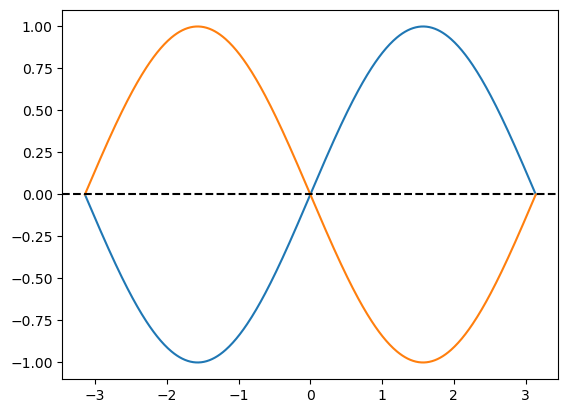

In [156]:
phi_0s = np.linspace(-np.pi, np.pi, 501)
trig_1 = np.cos(phi_0s+angs[0]-angs[1])
trig_n1 = np.cos(-phi_0s+angs[0]-angs[2])
plt.plot(phi_0s, trig_1)
plt.plot(phi_0s, trig_n1)
plt.axhline(0, c='k', ls='dashed')

0.0


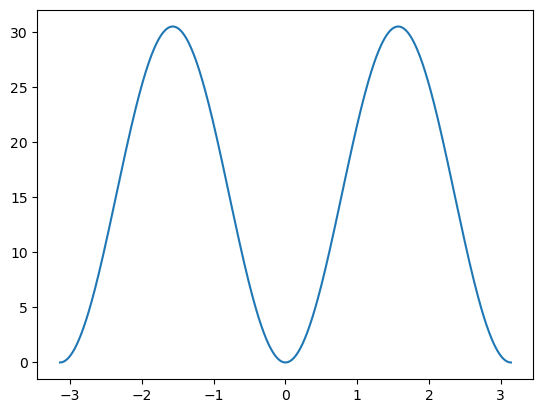

In [157]:
log_L_1 = (mags[1]**2/4)*(1+np.cos(2*phi_0s)*np.cos(2*(angs[0]-angs[1]))-np.sin(2*phi_0s)*np.sin(2*(angs[0]-angs[1])))
log_L_2 = (mags[2]**2/4)*(1+np.cos(2*phi_0s)*np.cos(2*(angs[0]-angs[2]))+np.sin(2*phi_0s)*np.sin(2*(angs[0]-angs[2])))
log_L = log_L_1 + log_L_2
plt.plot(phi_0s, log_L)
plt.plot(phi_0s[(trig_1>=0)*(trig_n1>=0)], log_L[(trig_1>=0)*(trig_n1>=0)])
print(np.max(log_L[(trig_1>=0)*(trig_n1>=0)]))